In [49]:

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.mask
import rasterio.plot
import numpy as np
import matplotlib.colors

In [13]:
img = "C:/Documents/RoofSense/pretraining/imgs/9-284-556.stack_4_5.tif"
msk = "C:/Documents/RoofSense/pretraining/msks/9-284-556.stack_4_5.tif"
srf = "C:/Documents/RoofSense/temp/9-284-556.surf.gpkg"



In [62]:
cmap = {0: (141, 211, 199, 85),  # Asphalt Shingles
    1: (255, 255, 179, 85),  # Bituminous Membranes
    2: (190, 186, 218, 85),  # Clay Tiles
    3: (251, 128, 114, 85),  # Loose Gravel
    4: (128, 117, 211, 85),  # Metal
    5: (253, 180, 100, 85),  # Solar Panels
    6: (179, 222, 105, 85),  # Vegetation
    7: (252, 205, 229, 85),  # Other
    8: (255, 255, 255, 85),  # __ignore__
    9: (128, 128, 128, 85),  #__invalid__
}
lc_colors = np.zeros((max(cmap.keys()) + 1, 4))
lc_colors[list(cmap.keys())] = list(cmap.values())
lc_colors = lc_colors[:, :3] / 255
_lc_cmap = matplotlib.colors.ListedColormap(lc_colors)
kwargs = {
    "cmap": _lc_cmap,
    "vmin": 0,
    "vmax": len(cmap),
    "interpolation": "none",
}

In [82]:
# Buffer the surfaces and discard the original geometry.
surf_buffers = gpd.read_file(srf)
# Dissolve the surfaces so that only their edges are buffered.
surf_buffers = surf_buffers.dissolve()

In [83]:
# NOTE: Rasterio performs a left spatial join to compute the difference between two objects so the corresponding method should be called on the attributes to preserve.
surf_buffers["geometry"]

0    MULTIPOLYGON (((84573.565 445913.627, 84569.96...
Name: geometry, dtype: geometry

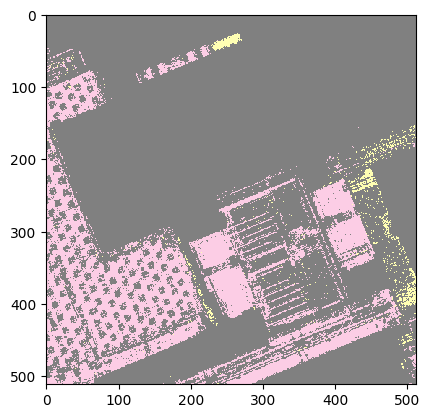

In [84]:
with rasterio.open(msk) as f:
    data = f.read()
    plt.imshow(data.squeeze(),**kwargs)

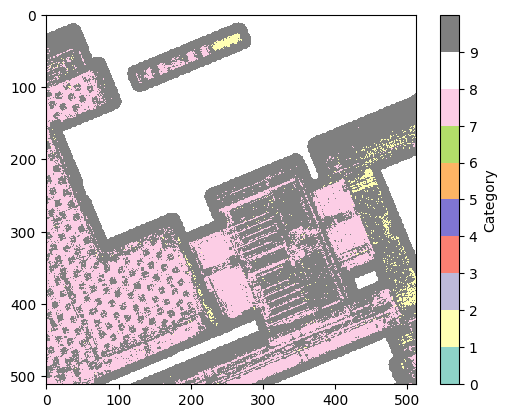

In [90]:
# Fix the background
with rasterio.open(msk) as f:
    out_meta=f.profile
    out_data, out_transform = rasterio.mask.mask(f,
                                                 shapes=surf_buffers["geometry"].buffer(3),
                                                 nodata=8,
                                                 indexes=1)
    plt.imshow(out_data.data, **kwargs)
    plt.colorbar(ticks=range(10), label='Category')

In [96]:
import scipy as sp
out_data=sp.signal.medfilt2d(out_data)

In [97]:
with rasterio.open(msk,mode="w",**out_meta) as f:
    f.write(out_data,indexes=1)